# Binned comparisons across all subjects- Jaccard Analysis of Segmentation Data
### updated permutation method ( jaccard indices not calculated within each permutation) 9/30/20
### Use this one

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random
%autosave 5

Autosaving every 5 seconds


### i. Import data

In [14]:
filename = '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/analysis/parsing_log_file/pickle/data_dict_pilots_b1_b2_b3_b4_b5_b6.p'
#filename = '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/analysis/parsing_log_file/pickle/data_dict_b6.p'
data_dict = pickle.load( open( filename, "rb" ) )
len(data_dict)

327

### ii. story files
#### a. import story files

In [15]:
directory_stories = '/Users/alexreblando/Documents/GitHub/ebs/behavioral_August2019/story_xlsx_files_RECORDED'

filenames_stories = glob.glob(directory_stories + '/*.xlsx')

dfs_stories = []
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_excel(filename))

#### b. organize putative event boundaries

In [16]:
#mark the boundaries with a '1'
#output: story_boundaries, where the first column has the location boundaries and the second column has the social
#boundaries

story_boundaries = dict()

#read in the location and social event values from the story files 
for s in range(16):
    this_story = int(dfs_stories[s]['story'].iloc[0])
    keys2 = dfs_stories[s]['locationEvent'].values
    keys3 = dfs_stories[s]['socialEvent'].values
    story_boundaries[this_story] = keys2[:, np.newaxis]
    story_boundaries[this_story] = np.concatenate((story_boundaries[this_story], keys3[:, np.newaxis]), axis = 1)
    
#mark the changes or boundaries from one event to another with a '1' and delete first two columns
for key in story_boundaries:
    location = story_boundaries[key][:,0]
    social = story_boundaries[key][:,1]
    for i in range(0, len(location)):  
        if location[i] > location[i-1]:
            location[i] = 7
    for i in range(0, len(location)):  
        if location[i] != 7:
            location[i] = 0
    for i in range(0, len(social)):
        if social[i] > social[i - 1]:
            social[i] = 7
    for i in range(0, len(social)):
        if social[i] != 7:
            social[i] = 0
    location[0] = 7
    social[0] = 7
    location2 = location > 1
    social2 = social > 1
    location2 = location2.astype(int)
    social2 = social2.astype(int)
    story_boundaries[key] = np.concatenate((story_boundaries[key], location2[:, np.newaxis]), axis = 1) 
    story_boundaries[key] = np.concatenate((story_boundaries[key], social2[:, np.newaxis]), axis = 1)
    story_boundaries[key] = np.delete(story_boundaries[key] ,np.s_[0:2],axis=1)

### iii. Exclusions
#### a. exclude participants who only pressed '1' or '9' (not including first row 10/14)

In [17]:
keys_to_del = []
for key in data_dict:
    kp = data_dict[key]['story_presses']
    kp_i = kp.iloc[1:]
    check_kp_i = len(set(kp_i))
    if check_kp_i == 1:
        #print(key)
        #print(data_dict[key]['prolific_id'].iloc[0])
        keys_to_del.append(key)
        
for i in range(0, len(keys_to_del)):
    print(keys_to_del[i])
    del data_dict[keys_to_del[i]]
    


/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot2/8/PARTICIPANT_1_online_exp_2020-05-11_12h52.50.131
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot3/4/PARTICIPANT_1_online_exp_2020-05-20_17h03.06.828
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/23_1_online_exp_2020-06-09_13h39.42.955
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/145_1_online_exp_2020-06-10_15h14.14.911
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/171_1_online_exp_2020-06-10_21h32.27.534
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/33_1_online_exp_2020-06-10_21h03.35.215
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b2/30/201_1_online_exp_2020-06-24_15h33.47.631
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online

#### b. Exclude participants who don't answer short answers

In [18]:
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/73_1_online_exp_2020-06-10_14h37.05.252']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b2/30/199_1_online_exp_2020-06-24_20h41.05.680']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b3/45/345_1_online_exp_2020-07-16_09h07.09.087']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b6/76/39_1_online_exp_2020-10-20_13h05.53.446']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b6/76/31_1_online_exp_2020-10-20_11h38.47.446']

#### c. exclude participant with no data

In [19]:
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b6/76/6_1_online_exp_2020-10-20_10h04.26.275']

#### c. Exclude participants who said said more than half the sentences were a boundary

In [20]:
keys_to_del = []

for key in data_dict:
    kp = data_dict[key]['story_presses']
    N_kp= np.sum(kp == 9)
    this_story = data_dict[key]['story'].iloc[0]
    half_story_len = np.rint(len(story_boundaries[this_story])/2)
    if N_kp >= half_story_len:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
        keys_to_del.append(key)
        
for i in range(0, len(keys_to_del)):
    del data_dict[keys_to_del[i]]

/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot2/8/PARTICIPANT_1_online_exp_2020-05-11_20h42.51.597
5ce5b9844cd8130019acba32
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot4/7/PARTICIPANT_1_online_exp_2020-05-27_21h05.22.618
5d46c556fb0ce0001a04fd01
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/18_1_online_exp_2020-06-06_14h58.27.858
571ceeb64ca277000953d1c1
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/21_1_online_exp_2020-06-06_15h20.03.392
5eda9f7c460b766ded73bdb7
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/24_1_online_exp_2020-06-09_20h39.35.048
5ea616a090d52b61615dfb3b
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/152_1_online_exp_2020-06-10_21h15.29.074
5d331b4c9ce6590019010930
/Users/alexreblando/Documents/GitHub/data_analys

In [21]:
len(data_dict)

265

#### d. Pickle data_dict in order to get group counts

In [22]:
pickle.dump( data_dict, open( 'check', "wb" ) )

# I. Separating the Priming Groups For Each Story
## A. group stories by subject and priming type
#### - output: loc_keys_r

In [41]:
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for key in data_dict:
    this_story = data_dict[key]['story'].iloc[0]
    keys = data_dict[key]['story_presses']
    p_type = data_dict[key]['p_type'].iloc[0]
    #print out the filenames and prolific ids of people who did not press "9" once
    occurrences = np.count_nonzero(keys == 9)
    if occurrences == 0:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 0:
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 1:
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 2:
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]

### i. Finding the number of participants in each category for each story
#### -output sums[story] = [total # of participants, no prime, loc primed, soc primed]

In [43]:
sums = {}

for key in all_keys_r:
    this_sum = []
    x, y = all_keys_r[key].shape
    this_sum.append(y)
    if key in none_keys_r:
        x, y = none_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in loc_keys_r:
        x, y = loc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in soc_keys_r:
        x, y = soc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    sums[key] = this_sum

## B. Convert keypresses from '9's and '1's to '1's and '0's
#### - output loc_keys
#### - WARNING: you can only run this once!!!!!! if you run twice, you must start from the beginning

In [44]:
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   

## C. Remove first sentence (first row) from all keypresses

In [45]:
list_keys = [all_keys, none_keys, loc_keys, soc_keys]
for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        list_keys[i][key] = np.delete(list_keys[i][key],(0), axis = 0)

# IV. Jaccard Analysis
## A. Creating partipant x sentence array for each story 
## -organized with No Prime participants first, followed by, Location Primed, and then Social Primed

In [46]:
keypress_array = {}
summary_vals = {}

for key in all_keys:
    print(key)
    # Index keypresses for each story
    none = none_keys[key].T
    n_none, y = none.shape
    print('none', none)
    loc = loc_keys[key].T
    n_loc, y = none.shape
    print('loc', loc)
    soc = soc_keys[key].T
    n_soc, y = none.shape
    print('soc', soc)
    # Concatening keypresses
    final = np.concatenate((none,loc,soc), axis = 0)
    # Putting the final array in a dictionary
    keypress_array[key] = final
    # Putting summary vals together
    summary_vals[key] = np.array([n_none, n_loc, n_soc])

11
none [[0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
  0 1 0 0]
 [0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
  0 1 0 0]
 [1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0
  1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0
  0 0 1 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1
  0 0 0 0]
 [1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1
  1 0 0 0]]
loc [[0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1
  0 0 1 1]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
  0 1 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 

## B. Jaccard Analysis creating participant x participant matrix

In [47]:
jc_array = {}

for key in keypress_array:
    n, y  = keypress_array[key].shape
    this_array = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            this_score = jaccard_score(keypress_array[key][i], keypress_array[key][j])
            this_array[i,j] = this_score
    jc_array[key] = this_array

## C. Binning each comparison
### 1. Making the mask for each type of bin 

In [48]:
colored_arrays = {}

for key in all_keys:
    # Index keypresses for each story
    none = none_keys[key].T
    none_c = copy.deepcopy(none)
    none_c[none >= 0] = 3
    loc = loc_keys[key].T
    loc_c = copy.deepcopy(loc)
    loc_c[loc >= 0] = 5
    soc = soc_keys[key].T
    soc_c = copy.deepcopy(soc)
    soc_c[soc >= 0] = 7
    # Concatening keypresses
    final = np.concatenate((none_c,loc_c,soc_c), axis = 0)
    # Putting the final array in a dictionary
    colored_arrays[key] = final

mask = {}

for key in colored_arrays:
    x, y = colored_arrays[key].shape
    this_array = np.zeros((x, x))
    for i in range(0,x):
        for j in range(0, x):
            first = np.amax(colored_arrays[key][i])
            second = np.amax(colored_arrays[key][j])
            mult = first*second
            this_array[i,j] = mult
    # Putting filled in array in dict
    mask[key] = this_array

In [49]:
mask[14].shape

(17, 17)

### 2. Binning

In [50]:
j_bins = {}

for key in jc_array:
    this_jbin = np.zeros((3,3))
    ######## NP - NP
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '9's
    this_mask[this_mask != 9] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '9's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[0,0] = val_sum/count
    ######## NP - loc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '15's
    this_mask[this_mask != 15] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '15's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[0,1] = val_sum/count
        this_jbin[1,0] = val_sum/count
    ######## NP - soc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '21's
    this_mask[this_mask != 21] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '21's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[0,2] = val_sum/count
        this_jbin[2,0] = val_sum/count
    ######## loc - loc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '25's
    this_mask[this_mask != 25] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '25's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[1,1] = val_sum/count
        this_jbin[1,1] = val_sum/count
    ######## loc - soc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '35's
    this_mask[this_mask != 35] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '35's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[1,2] = val_sum/count
        this_jbin[2,1] = val_sum/count
    ######## soc - soc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '49's
    this_mask[this_mask != 49] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '49's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[2,2] = val_sum/count
        this_jbin[2,2] = val_sum/count
    #######################################################################
    # Put this_jbin in j_bins dict
    j_bins[key] = this_jbin
    

## D. Plotting

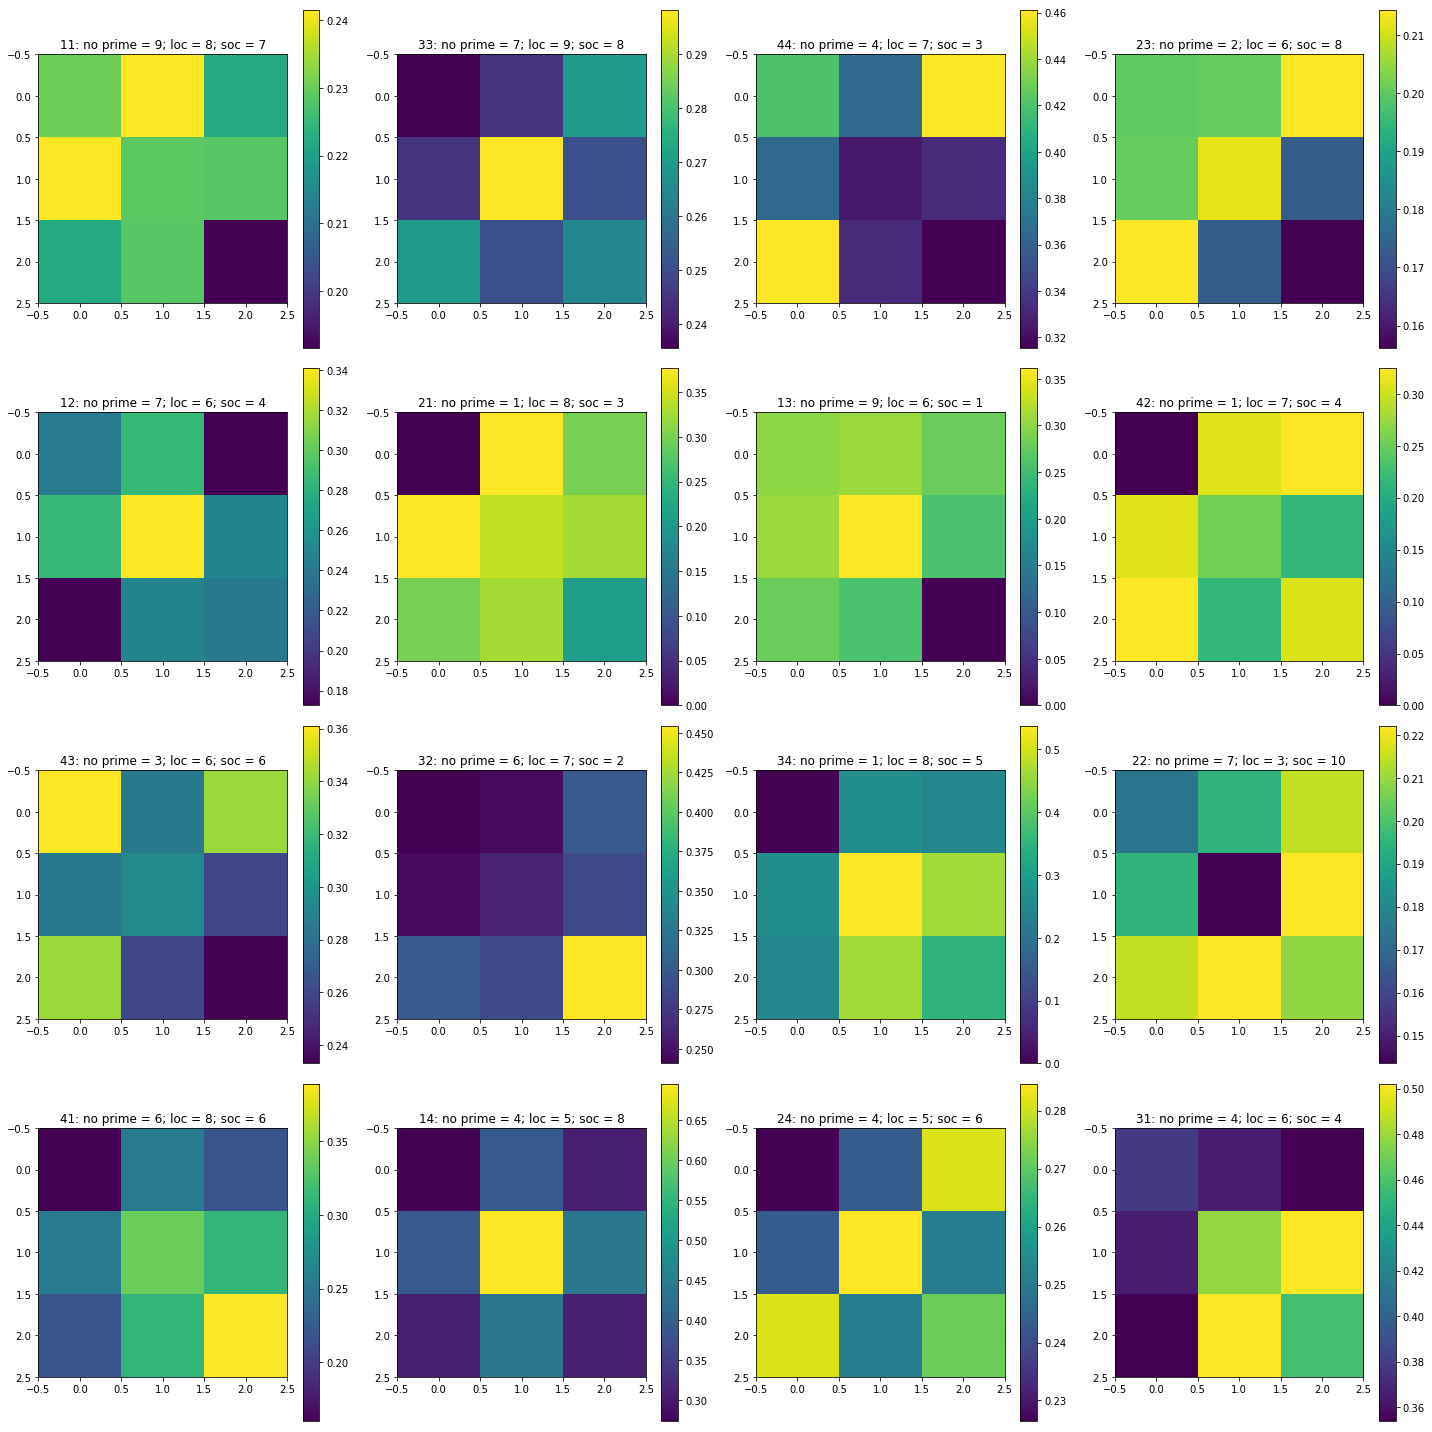

In [51]:
figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

i = 0
j = 0
for key in j_bins:
    # Make the plot
    im = axes[j, i].imshow(j_bins[key])
    
    #colorbar
    im.set_clim()
    figure.colorbar(im, ax=axes[j, i])
    
    #set title
    none_n = sums[key][1]
    loc_n = sums[key][2]
    soc_n = sums[key][3]
    axes[j, i].set_title(str(key) + ': no prime = ' + str(none_n) + '; loc = ' + str(loc_n) + '; soc = ' + str(soc_n))
    
    #changing i, j for next graph placement
    if i == 3:
        i = 0
        j += 1
    else:
        i += 1
    figure.tight_layout()

## E. Averaging across stories
### 1. Compute

In [52]:
# Concatenate Matrices along the third dimension
count = 0
for key in j_bins:
    # ONLY KEEP TEMPORARILY
    # Replace zeros with nans
    j_bins[key][j_bins[key] <= 0] = float('Nan')
    if count == 0:
        all_j_bins = j_bins[key]
        count =+ 1
    else:
        all_j_bins = np.dstack((all_j_bins, j_bins[key]))

# NanMean
avg_all_j_bins_actual = np.nanmean(all_j_bins, axis = 2)

### 2. Plot

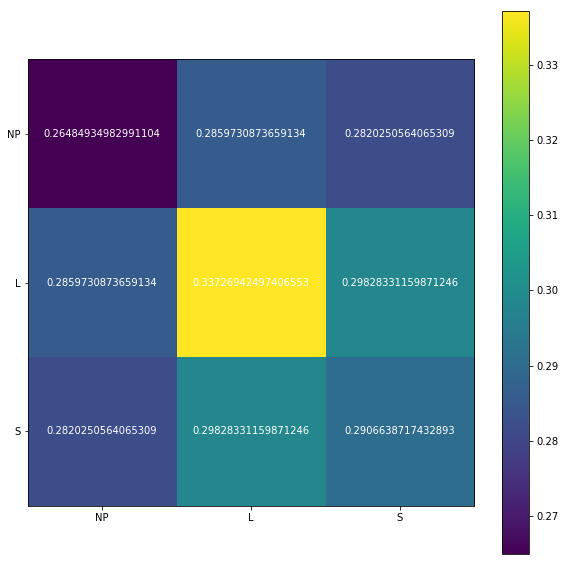

In [53]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_all_j_bins_actual)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['NP', 'L', 'S']
ax.set_yticks([0,1,2])
ax.set_yticklabels(x_label_list)

# Adding values to boxes
# Loop over data dimensions and create text annotations.
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(i, j, avg_all_j_bins_actual[j, i], ha="center", va="center", color="w")

# V. Permutation Testing
## A. Permute jc_array
## - mask data to bin the types of comparisons
## - average the types of comparisons
## - organize the types of comparisons in 3 x 3 matrix
## - append the resulting matrix into array with other permutations' matrices

In [54]:
this = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(this)

randperm = np.random.permutation(3)
print(randperm)
this = this[randperm, :]
print(this)
this.shape[1]


[[1 2 3]
 [4 5 6]
 [7 8 9]]
[0 2 1]
[[1 2 3]
 [7 8 9]
 [4 5 6]]


3

In [55]:
N_perms = 1000
count_it = 0
sim_vals = []
for i in range(0, N_perms):
    ## permute the rows and columns of jc_array to randomize the eventual binning of jaccard indices
    rp_jc_array = {}
    for key in all_keys:
        # Deep copy the original array
        this_array = np.copy(jc_array[key])
        # Generate a permutation
        this_perm = np.random.permutation(this_array.shape[0])
        # Permute the columns
        this_array = this_array[:, this_perm]
        # Permute the rows
        this_array = this_array[this_perm, :]
        # Put in Dictionary
        rp_jc_array[key] = this_array
    
    ## Binning
    j_bins = {}

    for key in rp_jc_array:
        this_jbin = np.zeros((3,3))
        ######## NP - NP
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '9's
        this_mask[this_mask != 9] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '9's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[0,0] = val_sum/count
        ######## NP - loc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '15's
        this_mask[this_mask != 15] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '15's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[0,1] = val_sum/count
            this_jbin[1,0] = val_sum/count
        ######## NP - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '21's
        this_mask[this_mask != 21] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '21's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[0,2] = val_sum/count
            this_jbin[2,0] = val_sum/count
        ######## loc - loc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '25's
        this_mask[this_mask != 25] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '25's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[1,1] = val_sum/count
            this_jbin[1,1] = val_sum/count
        ######## loc - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '35's
        this_mask[this_mask != 35] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '35's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[1,2] = val_sum/count
            this_jbin[2,1] = val_sum/count
        ######## soc - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '49's
        this_mask[this_mask != 49] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '49's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[2,2] = val_sum/count
            this_jbin[2,2] = val_sum/count
        #######################################################################
        # Put this_jbin in j_bins dict
        j_bins[key] = this_jbin
        
    ## Avg across stories
    #Concatenate Matrices along the third dimension
    count = 0
    for key in j_bins:
        # ONLY KEEP TEMPORARILY
        # Replace zeros with nans
        j_bins[key][j_bins[key] <= 0] = float('Nan')
        if count == 0:
            all_j_bins = j_bins[key]
            count =+ 1
        else:
            all_j_bins = np.dstack((all_j_bins, j_bins[key]))

    # NanMean
    avg_all_j_bins = np.nanmean(all_j_bins, axis = 2)
    
    print(avg_all_j_bins)
    
    # Add avg_all_j_bins to others of other iterations
    if count_it == 0:
        all_perms = avg_all_j_bins
        count_it += 1
    else:
        all_perms = np.dstack((all_perms, avg_all_j_bins))
        
    # Calculate similarity values and append
    sim_vals.append(((avg_all_j_bins[1,1] + avg_all_j_bins[2,2])/2) - avg_all_j_bins[1,2])


[[0.3011195  0.27753642 0.28644164]
 [0.27753642 0.28975773 0.29570859]
 [0.28644164 0.29570859 0.32214573]]
[[0.27776283 0.29979503 0.29437538]
 [0.29979503 0.28719068 0.29399631]
 [0.29437538 0.29399631 0.32137321]]
[[0.27392581 0.29032238 0.29052465]
 [0.29032238 0.29960548 0.30147659]
 [0.29052465 0.30147659 0.32846046]]
[[0.31053895 0.30577894 0.30833771]
 [0.30577894 0.29650523 0.29685592]
 [0.30833771 0.29685592 0.28177594]]
[[0.2656714  0.29758192 0.30679016]
 [0.29758192 0.30109214 0.30907644]
 [0.30679016 0.30907644 0.31621002]]
[[0.28357313 0.31356701 0.30157343]
 [0.31356701 0.28834256 0.28810448]
 [0.30157343 0.28810448 0.29675783]]
[[0.26947829 0.30363072 0.31418355]
 [0.30363072 0.27482557 0.30730799]
 [0.31418355 0.30730799 0.30222976]]
[[0.29309926 0.30387423 0.31988252]
 [0.30387423 0.28463167 0.29465598]
 [0.31988252 0.29465598 0.29198476]]
[[0.31533901 0.26825762 0.28724324]
 [0.26825762 0.26945597 0.29719864]
 [0.28724324 0.29719864 0.2984782 ]]
[[0.29307588 0.2814

[[0.27002248 0.30189663 0.28950399]
 [0.30189663 0.28901753 0.29200874]
 [0.28950399 0.29200874 0.30242137]]
[[0.28739048 0.3103467  0.29833634]
 [0.3103467  0.30684984 0.28449455]
 [0.29833634 0.28449455 0.26314829]]
[[0.28702669 0.29635541 0.30508412]
 [0.29635541 0.28847751 0.30263638]
 [0.30508412 0.30263638 0.28599891]]
[[0.26044329 0.29345014 0.29322818]
 [0.29345014 0.29843222 0.30402303]
 [0.29322818 0.30402303 0.30454546]]
[[0.26264179 0.30589191 0.29910284]
 [0.30589191 0.296711   0.3036068 ]
 [0.29910284 0.3036068  0.28425242]]
[[0.30647246 0.31253187 0.30271845]
 [0.31253187 0.32048378 0.28838684]
 [0.30271845 0.28838684 0.28871035]]
[[0.25324602 0.26998365 0.24443134]
 [0.26998365 0.32414389 0.29438911]
 [0.24443134 0.29438911 0.28705438]]
[[0.29658761 0.30091119 0.27688348]
 [0.30091119 0.2975667  0.27840794]
 [0.27688348 0.27840794 0.28739812]]
[[0.30818552 0.29293992 0.28728504]
 [0.29293992 0.28895391 0.29657842]
 [0.28728504 0.29657842 0.31212753]]
[[0.29072939 0.2856

[[0.31781768 0.31851079 0.31233928]
 [0.31851079 0.2735927  0.30067884]
 [0.31233928 0.30067884 0.29040641]]
[[0.28518965 0.27958439 0.28619734]
 [0.27958439 0.29324529 0.30707352]
 [0.28619734 0.30707352 0.29498622]]
[[0.3083085  0.28639394 0.29848265]
 [0.28639394 0.28960767 0.29108906]
 [0.29848265 0.29108906 0.28721685]]
[[0.27705371 0.28321751 0.30986738]
 [0.28321751 0.29311267 0.30774751]
 [0.30986738 0.30774751 0.29478469]]
[[0.27291027 0.30514558 0.30698432]
 [0.30514558 0.27552033 0.29209692]
 [0.30698432 0.29209692 0.2972227 ]]
[[0.31385777 0.27435275 0.30833522]
 [0.27435275 0.27570528 0.28174325]
 [0.30833522 0.28174325 0.3057973 ]]
[[0.27156613 0.29611599 0.29325647]
 [0.29611599 0.30254171 0.29644495]
 [0.29325647 0.29644495 0.29411169]]
[[0.29551555 0.28371045 0.28683959]
 [0.28371045 0.2721372  0.29007646]
 [0.28683959 0.29007646 0.29954974]]
[[0.27292873 0.26478327 0.26396979]
 [0.26478327 0.29057605 0.30712747]
 [0.26396979 0.30712747 0.29967519]]
[[0.29587911 0.2911

[[0.28250693 0.29010648 0.29357036]
 [0.29010648 0.29414173 0.28857391]
 [0.29357036 0.28857391 0.27064889]]
[[0.29543632 0.27181187 0.31483192]
 [0.27181187 0.27523515 0.30318955]
 [0.31483192 0.30318955 0.33564954]]
[[0.27103616 0.3094495  0.30925716]
 [0.3094495  0.29529832 0.3104145 ]
 [0.30925716 0.3104145  0.30396583]]
[[0.27274774 0.30909702 0.30664964]
 [0.30909702 0.30737798 0.29775101]
 [0.30664964 0.29775101 0.24997716]]
[[0.27718465 0.31068281 0.28529412]
 [0.31068281 0.3097133  0.29680376]
 [0.28529412 0.29680376 0.24990946]]
[[0.29261839 0.30230036 0.30693089]
 [0.30230036 0.28170752 0.2947972 ]
 [0.30693089 0.2947972  0.29787233]]
[[0.27129971 0.29178499 0.32149514]
 [0.29178499 0.2831852  0.29687378]
 [0.32149514 0.29687378 0.32969807]]
[[0.27602429 0.28023849 0.25484459]
 [0.28023849 0.28825606 0.30096909]
 [0.25484459 0.30096909 0.30454421]]
[[0.26318886 0.29521332 0.30016225]
 [0.29521332 0.29179745 0.31723201]
 [0.30016225 0.31723201 0.31565035]]
[[0.31015731 0.3013

[[0.2882669  0.31756925 0.30692757]
 [0.31756925 0.28933497 0.2944406 ]
 [0.30692757 0.2944406  0.30083835]]
[[0.29989536 0.30682184 0.27709178]
 [0.30682184 0.27958193 0.28535368]
 [0.27709178 0.28535368 0.29934294]]
[[0.27176062 0.28266534 0.27980024]
 [0.28266534 0.30204018 0.30624015]
 [0.27980024 0.30624015 0.29643396]]
[[0.29323759 0.28193006 0.28979629]
 [0.28193006 0.28491306 0.30238631]
 [0.28979629 0.30238631 0.3154604 ]]
[[0.25586615 0.30305175 0.29782773]
 [0.30305175 0.29680008 0.30301518]
 [0.29782773 0.30301518 0.302658  ]]
[[0.27587292 0.27150664 0.26930177]
 [0.27150664 0.31997555 0.29828099]
 [0.26930177 0.29828099 0.28400084]]
[[0.27967117 0.27649419 0.28645138]
 [0.27649419 0.29634417 0.30712099]
 [0.28645138 0.30712099 0.30017416]]
[[0.29680954 0.29422852 0.29093877]
 [0.29422852 0.27829478 0.28828893]
 [0.29093877 0.28828893 0.29063268]]
[[0.2868293  0.25602525 0.27593826]
 [0.25602525 0.31245056 0.29552357]
 [0.27593826 0.29552357 0.30775948]]
[[0.297789   0.3140

[[0.31396328 0.31222627 0.2929141 ]
 [0.31222627 0.2825071  0.29068376]
 [0.2929141  0.29068376 0.29141606]]
[[0.29621762 0.31919626 0.27805797]
 [0.31919626 0.33762619 0.27729356]
 [0.27805797 0.27729356 0.27150059]]
[[0.28277797 0.29811623 0.31301854]
 [0.29811623 0.30496737 0.30353446]
 [0.31301854 0.30353446 0.2745507 ]]
[[0.28503433 0.27876057 0.27502406]
 [0.27876057 0.29603027 0.29759201]
 [0.27502406 0.29759201 0.28411846]]
[[0.30528591 0.29406014 0.285175  ]
 [0.29406014 0.29954373 0.29592445]
 [0.285175   0.29592445 0.27219334]]
[[0.27326976 0.28788973 0.29086754]
 [0.28788973 0.30309511 0.28951949]
 [0.29086754 0.28951949 0.30049616]]
[[0.24093037 0.29980754 0.26018953]
 [0.29980754 0.33170877 0.30462025]
 [0.26018953 0.30462025 0.25925259]]
[[0.29750513 0.28070771 0.28566371]
 [0.28070771 0.31133138 0.29606604]
 [0.28566371 0.29606604 0.30285159]]
[[0.32578419 0.26888166 0.27266999]
 [0.26888166 0.27356833 0.28355959]
 [0.27266999 0.28355959 0.32377542]]
[[0.29927598 0.3070

[[0.28136617 0.30071497 0.28566595]
 [0.30071497 0.29458438 0.29850622]
 [0.28566595 0.29850622 0.29141346]]
[[0.29433856 0.30957625 0.30186967]
 [0.30957625 0.293872   0.28109727]
 [0.30186967 0.28109727 0.31116943]]
[[0.29962037 0.26729458 0.27647298]
 [0.26729458 0.29373645 0.30258684]
 [0.27647298 0.30258684 0.31196969]]
[[0.28967847 0.29044326 0.30239417]
 [0.29044326 0.28124017 0.28262685]
 [0.30239417 0.28262685 0.28409566]]
[[0.29611133 0.28794583 0.25925517]
 [0.28794583 0.2964206  0.28850375]
 [0.25925517 0.28850375 0.27280105]]
[[0.30290943 0.29435528 0.30157666]
 [0.29435528 0.29341226 0.2980074 ]
 [0.30157666 0.2980074  0.29772217]]
[[0.3108875  0.28646783 0.3016134 ]
 [0.28646783 0.26969003 0.30476933]
 [0.3016134  0.30476933 0.31279313]]
[[0.2695431  0.31776253 0.29869521]
 [0.31776253 0.28184282 0.29414958]
 [0.29869521 0.29414958 0.29561057]]
[[0.29234437 0.30279947 0.32749754]
 [0.30279947 0.27205593 0.28415084]
 [0.32749754 0.28415084 0.2854176 ]]
[[0.26550346 0.2799

[[0.2994534  0.30569216 0.3269456 ]
 [0.30569216 0.27586343 0.29801594]
 [0.3269456  0.29801594 0.30838743]]
[[0.24712356 0.28546569 0.30323752]
 [0.28546569 0.28657908 0.31509922]
 [0.30323752 0.31509922 0.3596332 ]]
[[0.3303519  0.29957043 0.2997974 ]
 [0.29957043 0.27828026 0.293181  ]
 [0.2997974  0.293181   0.2935512 ]]
[[0.33005541 0.28411331 0.32273213]
 [0.28411331 0.26421446 0.29145989]
 [0.32273213 0.29145989 0.32320708]]
[[0.30005375 0.29169775 0.29348433]
 [0.29169775 0.30147217 0.28587244]
 [0.29348433 0.28587244 0.30062919]]
[[0.30410113 0.28496372 0.28317126]
 [0.28496372 0.30351421 0.29573288]
 [0.28317126 0.29573288 0.30871037]]
[[0.30500642 0.32047456 0.28057109]
 [0.32047456 0.31907007 0.28692127]
 [0.28057109 0.28692127 0.26156069]]
[[0.26562589 0.30575591 0.28999141]
 [0.30575591 0.30393053 0.30482606]
 [0.28999141 0.30482606 0.28838255]]
[[0.29360827 0.31338387 0.30397608]
 [0.31338387 0.28937073 0.30691518]
 [0.30397608 0.30691518 0.2823636 ]]
[[0.29950692 0.3077

[[0.28647536 0.28707327 0.26720468]
 [0.28707327 0.31197159 0.302681  ]
 [0.26720468 0.302681   0.27320202]]
[[0.30476227 0.28924587 0.31232233]
 [0.28924587 0.27190496 0.2888636 ]
 [0.31232233 0.2888636  0.3158191 ]]
[[0.2623225  0.28903849 0.30628921]
 [0.28903849 0.3018886  0.30658784]
 [0.30628921 0.30658784 0.32103145]]
[[0.27974381 0.29244659 0.26565209]
 [0.29244659 0.31682882 0.29100929]
 [0.26565209 0.29100929 0.25536266]]
[[0.2818856  0.30110925 0.3088627 ]
 [0.30110925 0.27382933 0.29120633]
 [0.3088627  0.29120633 0.332056  ]]
[[0.25962427 0.28240752 0.27564968]
 [0.28240752 0.31662492 0.31362709]
 [0.27564968 0.31362709 0.29087399]]
[[0.27510601 0.28344514 0.27029763]
 [0.28344514 0.31613638 0.29732347]
 [0.27029763 0.29732347 0.27028007]]
[[0.25293939 0.26013408 0.27462613]
 [0.26013408 0.30712657 0.29907136]
 [0.27462613 0.29907136 0.30749536]]
[[0.30569797 0.31303912 0.3162925 ]
 [0.31303912 0.28193355 0.28727337]
 [0.3162925  0.28727337 0.27042479]]
[[0.28592575 0.3001

[[0.30076998 0.27222993 0.28660709]
 [0.27222993 0.29638471 0.30552605]
 [0.28660709 0.30552605 0.32677873]]
[[0.28949227 0.30757514 0.31158949]
 [0.30757514 0.27802404 0.28628614]
 [0.31158949 0.28628614 0.30241922]]
[[0.32036089 0.2802302  0.29972225]
 [0.2802302  0.27052281 0.28103108]
 [0.29972225 0.28103108 0.30931716]]
[[0.28609741 0.29514667 0.33293876]
 [0.29514667 0.2798331  0.30953338]
 [0.33293876 0.30953338 0.30188812]]
[[0.26147641 0.30523044 0.29828912]
 [0.30523044 0.30969112 0.30111436]
 [0.29828912 0.30111436 0.29759103]]
[[0.28100688 0.31369723 0.29434594]
 [0.31369723 0.29638519 0.29964927]
 [0.29434594 0.29964927 0.26594553]]
[[0.29580552 0.31347896 0.32020573]
 [0.31347896 0.27229739 0.30163199]
 [0.32020573 0.30163199 0.30038709]]
[[0.29259046 0.3192101  0.30619976]
 [0.3192101  0.31229583 0.30314676]
 [0.30619976 0.30314676 0.27687147]]
[[0.24195453 0.27634586 0.26567094]
 [0.27634586 0.30032727 0.30747778]
 [0.26567094 0.30747778 0.32136374]]
[[0.27047997 0.3057

[[0.30729452 0.30789439 0.30266279]
 [0.30789439 0.28167303 0.28562845]
 [0.30266279 0.28562845 0.28308086]]
[[0.29081008 0.3066486  0.30052   ]
 [0.3066486  0.28690493 0.2998013 ]
 [0.30052    0.2998013  0.28554031]]
[[0.28899803 0.30232836 0.30408032]
 [0.30232836 0.30385607 0.30006874]
 [0.30408032 0.30006874 0.27481733]]
[[0.2760601  0.29776671 0.3253145 ]
 [0.29776671 0.28223797 0.30138536]
 [0.3253145  0.30138536 0.31124675]]
[[0.28108105 0.27326384 0.26150586]
 [0.27326384 0.304861   0.2908422 ]
 [0.26150586 0.2908422  0.2846123 ]]
[[0.3312576  0.31128086 0.31127304]
 [0.31128086 0.30337456 0.28727316]
 [0.31127304 0.28727316 0.27754603]]
[[0.26628256 0.29382411 0.30888093]
 [0.29382411 0.28840369 0.31526074]
 [0.30888093 0.31526074 0.29048015]]
[[0.28867747 0.29578726 0.31951327]
 [0.29578726 0.29900968 0.29797137]
 [0.31951327 0.29797137 0.30382047]]
[[0.23784905 0.25389565 0.27606439]
 [0.25389565 0.29337719 0.31436127]
 [0.27606439 0.31436127 0.31227333]]
[[0.27255418 0.2891

[[0.27632028 0.30683366 0.32396869]
 [0.30683366 0.29346742 0.30092604]
 [0.32396869 0.30092604 0.29157463]]
[[0.27310473 0.28203322 0.31561603]
 [0.28203322 0.28392843 0.29600694]
 [0.31561603 0.29600694 0.31520687]]
[[0.2587891  0.29891262 0.31195588]
 [0.29891262 0.28481349 0.29973077]
 [0.31195588 0.29973077 0.29762186]]
[[0.27095163 0.28685918 0.29729017]
 [0.28685918 0.31145608 0.28296864]
 [0.29729017 0.28296864 0.32129907]]
[[0.28205362 0.29939371 0.29897887]
 [0.29939371 0.29289924 0.29205021]
 [0.29897887 0.29205021 0.29308007]]
[[0.27009781 0.28471159 0.30017798]
 [0.28471159 0.30043421 0.29852175]
 [0.30017798 0.29852175 0.29223163]]
[[0.31636475 0.29333961 0.33193193]
 [0.29333961 0.29911305 0.28334033]
 [0.33193193 0.28334033 0.29433786]]
[[0.33578401 0.29922465 0.31635105]
 [0.29922465 0.27488885 0.30266028]
 [0.31635105 0.30266028 0.27428203]]
[[0.27982062 0.31930079 0.29952044]
 [0.31930079 0.29457622 0.28954078]
 [0.29952044 0.28954078 0.28508177]]
[[0.32838579 0.2848

[[0.28161283 0.28678253 0.29695372]
 [0.28678253 0.29003577 0.30161272]
 [0.29695372 0.30161272 0.28039209]]
[[0.28122377 0.29507722 0.27653467]
 [0.29507722 0.31301992 0.29678001]
 [0.27653467 0.29678001 0.27814199]]
[[0.2677875  0.31660982 0.29407871]
 [0.31660982 0.29615504 0.29910338]
 [0.29407871 0.29910338 0.26589607]]
[[0.28073896 0.30207035 0.3084701 ]
 [0.30207035 0.29358895 0.30776659]
 [0.3084701  0.30776659 0.29509907]]
[[0.28198996 0.27555898 0.27689857]
 [0.27555898 0.29009836 0.28461401]
 [0.27689857 0.28461401 0.29981799]]
[[0.31017703 0.31214306 0.31579423]
 [0.31214306 0.28047035 0.29105249]
 [0.31579423 0.29105249 0.29364423]]
[[0.30229407 0.30688277 0.29034849]
 [0.30688277 0.30641428 0.28814569]
 [0.29034849 0.28814569 0.27519132]]
[[0.28056775 0.3135971  0.28294156]
 [0.3135971  0.29876654 0.28047969]
 [0.28294156 0.28047969 0.28611363]]
[[0.24543243 0.30229823 0.31952969]
 [0.30229823 0.27823106 0.29771275]
 [0.31952969 0.29771275 0.33820998]]
[[0.27583932 0.3171

## B. Avg matrices and plot

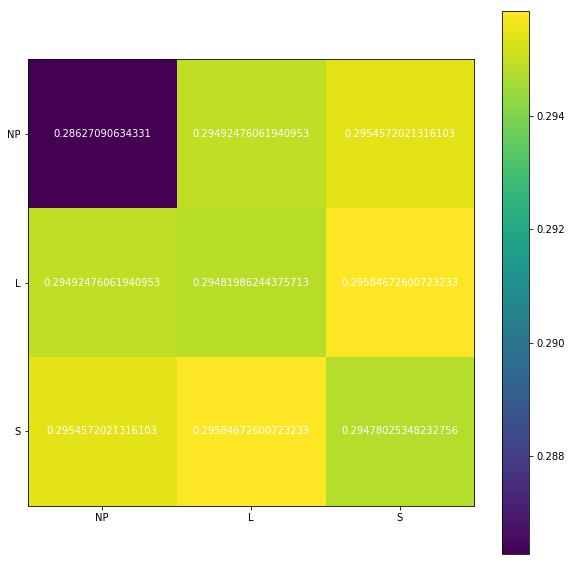

In [56]:
avg_perm = np.mean(all_perms, axis = 2)

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_perm)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['NP', 'L', 'S']
ax.set_yticks([0,1,2])
ax.set_yticklabels(x_label_list)

# Adding values to boxes
# Loop over data dimensions and create text annotations.
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(i, j, avg_perm[j, i], ha="center", va="center", color="w")

## C. Calculate p-value for each box and plot matrix of p-values

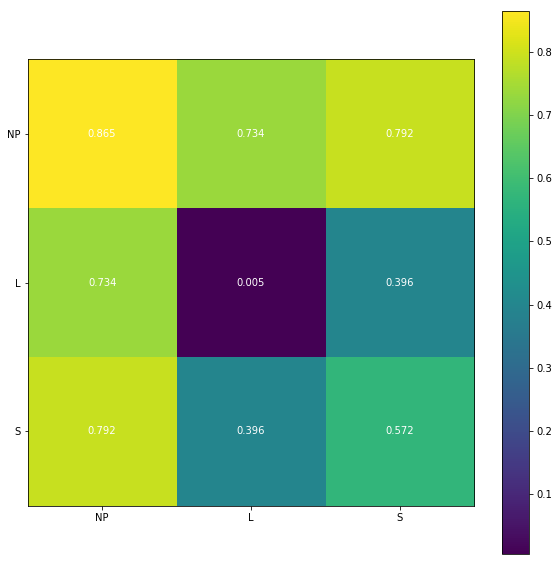

In [57]:
p_vals = np.zeros((3,3))

for i in range(0,3):
    for j in range(0, 3):
        these_vals = all_perms[i, j, :]
        p_vals[i,j] = ((these_vals > avg_all_j_bins_actual[i,j]).sum())/N_perms

# Plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(p_vals)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['NP', 'L', 'S']
ax.set_yticks([0,1,2])
ax.set_yticklabels(x_label_list)

# Adding values to boxes
# Loop over data dimensions and create text annotations.
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(i, j, p_vals[j, i], ha="center", va="center", color="w")

## D. Similarity of keypresses within a priming group
### 1. Calculate the actual similarity value

In [58]:
actual_sim_val = ((avg_all_j_bins_actual[1,1] + avg_all_j_bins_actual[2,2])/2) - avg_all_j_bins_actual[1,2]

### 2. Find the p-value this value

The p value is  0.058


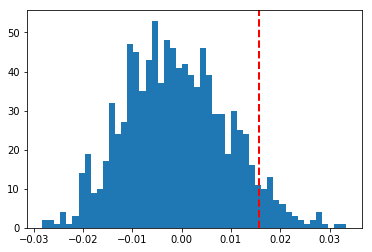

In [59]:
# convert list of PEs to np
sims = np.asarray(sim_vals)
# Plot the histogram
plt.hist(sims, bins = 50)
# Show the actual data
plt.axvline(x=actual_sim_val, color='r', linestyle='dashed', linewidth=2)
# Calculate the P-value
p_val = ((sims > actual_sim_val).sum())/1000
print('The p value is ', p_val)

In [27]:
avg_all_j_bins_actual

array([[0.26026807, 0.27936888, 0.27633234],
       [0.27936888, 0.33185456, 0.29770456],
       [0.27633234, 0.29770456, 0.25888653]])